# =Harmonization & Feature Engineering

**Objective:** Create the unified `D_public` dataset by applying feature engineering (normalization, encoding) and concatenating all three harmonized datasets.

---

## What This Notebook Does

1. **Load and harmonize** all three preprocessed datasets
2. **Consolidate rare categories** (<1% frequency → "Other")
3. **Normalize numerical features** (StandardScaler)
4. **One-hot encode categorical features**
5. **Create unified dataset** `D_public` by concatenating
6. **Validate** final dataset structure
7. **Save** harmonized dataset for train/test splitting

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.append('..')

from src.data_harmonization import (
    harmonize_dataset,
    create_unified_dataset,
    get_feature_summary
)

from src.feature_engineering import (
    prepare_for_modeling,
    identify_feature_types,
    consolidate_rare_categories
)

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Harmonize Datasets

Load preprocessed datasets and apply feature harmonization.

In [2]:
# Define paths
processed_dir = Path('../data/processed')

# Load datasets
print("Loading preprocessed datasets...\n")

telco = pd.read_csv(processed_dir / 'telco_processed.csv')
bank = pd.read_csv(processed_dir / 'bank_processed.csv')
ecomm = pd.read_csv(processed_dir / 'ecomm_processed.csv')

print(f"Telco:      {telco.shape}")
print(f"Bank:       {bank.shape}")
print(f"E-commerce: {ecomm.shape}")
print(f"\nTotal: {telco.shape[0] + bank.shape[0] + ecomm.shape[0]:,} observations")

Loading preprocessed datasets...

Telco:      (7043, 20)
Bank:       (10000, 11)
E-commerce: (5630, 26)

Total: 22,673 observations


In [3]:
# Harmonize datasets
print("\nApplying harmonization...\n")
print("="*70)

telco_h = harmonize_dataset(telco, 'telco', add_source_column=True)
print(f"✓ Telco harmonized: {telco_h.shape}")

bank_h = harmonize_dataset(bank, 'bank', add_source_column=True)
print(f"✓ Bank harmonized: {bank_h.shape}")

ecomm_h = harmonize_dataset(ecomm, 'ecommerce', add_source_column=True)
print(f"✓ E-commerce harmonized: {ecomm_h.shape}")

print("\nHarmonization complete!")


Applying harmonization...

✓ Telco harmonized: (7043, 21)
✓ Bank harmonized: (10000, 12)
✓ E-commerce harmonized: (5630, 27)

Harmonization complete!


## 2. Create Unified Dataset (Pre-Engineering)

Concatenate all three datasets into `D_public_raw` before feature engineering.

In [4]:
# Create unified dataset
harmonized_datasets = {
    'telco': telco_h,
    'bank': bank_h,
    'ecommerce': ecomm_h
}

D_public_raw = create_unified_dataset(harmonized_datasets, align_features=True)

print(f"\nUnified Dataset Shape: {D_public_raw.shape}")
print(f"Total Observations: {len(D_public_raw):,}")
print(f"Total Features: {D_public_raw.shape[1]}")

# Dataset source distribution
print("\nDataset Source Distribution:")
print(D_public_raw['dataset_source'].value_counts())

# Churn rate
overall_churn_rate = D_public_raw['churned'].mean()
print(f"\nOverall Churn Rate: {overall_churn_rate:.3f} ({overall_churn_rate*100:.1f}%)")


Unified Dataset Shape: (22673, 49)
Total Observations: 22,673
Total Features: 49

Dataset Source Distribution:
dataset_source
bank         10000
telco         7043
ecommerce     5630
Name: count, dtype: int64

Overall Churn Rate: 0.214 (21.4%)


## 3. Examine Missing Values

Check which features have missing values across the unified dataset.

Features with Missing Values (44 total):

                                     Missing_Count  Missing_Pct
OrderAmountHikeFromlastYear_missing          17043    75.168703
NumberOfDeviceRegistered                     17043    75.168703
PreferedOrderCat                             17043    75.168703
SatisfactionScore                            17043    75.168703
MaritalStatus                                17043    75.168703
NumberOfAddress                              17043    75.168703
Complain                                     17043    75.168703
OrderAmountHikeFromlastYear                  17043    75.168703
CouponUsed                                   17043    75.168703
recency                                      17043    75.168703
Tenure_missing                               17043    75.168703
WarehouseToHome_missing                      17043    75.168703
PreferredLoginDevice                         17043    75.168703
HourSpendOnApp                               17043    75.16870

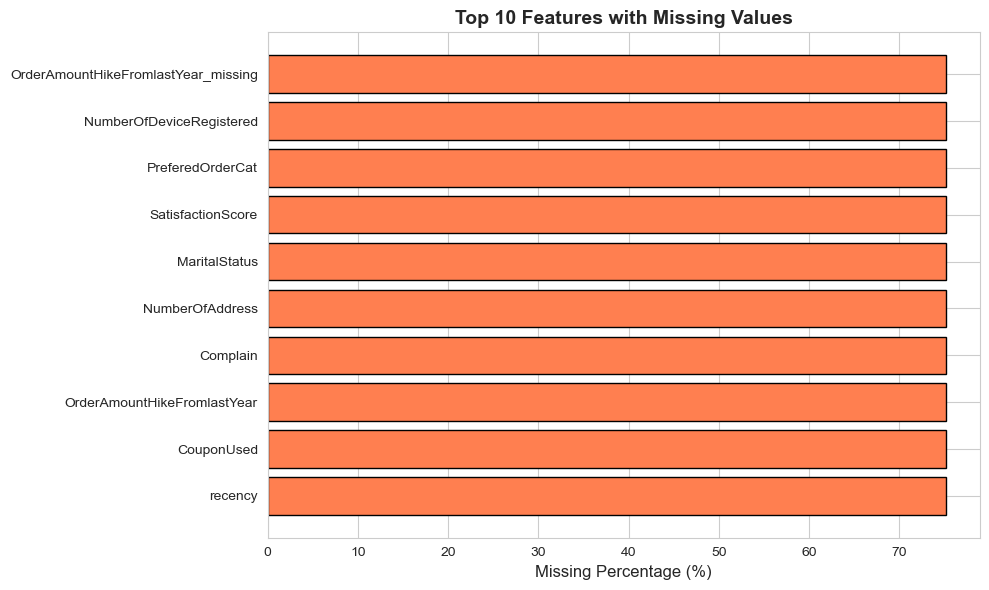


Note: Missing values are expected when combining datasets with different feature sets.
These will be handled as NaN indicators or filled appropriately.


In [5]:
# Missing values analysis
missing_summary = D_public_raw.isnull().sum()
missing_pct = (missing_summary / len(D_public_raw)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Pct': missing_pct
}).sort_values('Missing_Pct', ascending=False)

# Show only features with >0% missing
missing_features = missing_df[missing_df['Missing_Pct'] > 0]

if len(missing_features) > 0:
    print(f"Features with Missing Values ({len(missing_features)} total):\n")
    print(missing_features.head(15))
    
    # Visualize top 10 features with missing values
    top_missing = missing_features.head(10)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_missing.index, top_missing['Missing_Pct'], color='coral', edgecolor='black')
    ax.set_xlabel('Missing Percentage (%)', fontsize=12)
    ax.set_title('Top 10 Features with Missing Values', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('../results/figures/day9_missing_values.png', dpi=150)
    plt.show()
else:
    print("No missing values found! ✓")

print("\nNote: Missing values are expected when combining datasets with different feature sets.")
print("These will be handled as NaN indicators or filled appropriately.")

## 4. Feature Type Identification

Identify numerical, categorical, and binary features for appropriate processing.

In [6]:
# Identify feature types
feature_types = identify_feature_types(D_public_raw)

print("Feature Type Summary:\n")
print("="*70)
print(f"Numerical Features:   {len(feature_types['numerical'])}")
print(f"Categorical Features: {len(feature_types['categorical'])}")
print(f"Binary Features:      {len(feature_types['binary'])}")
print(f"Target Variable:      {feature_types['target']}")
print(f"Identifier:           {feature_types['identifier']}")

print(f"\nNumerical Features ({len(feature_types['numerical'])}):")
print(feature_types['numerical'])

print(f"\nCategorical Features ({len(feature_types['categorical'])}):")
print(feature_types['categorical'])

print(f"\nBinary Features ({len(feature_types['binary'])}):")
print(feature_types['binary'][:10], "... (showing first 10)")

Feature Type Summary:

Numerical Features:   16
Categorical Features: 20
Binary Features:      11
Target Variable:      ['churned']
Identifier:           ['dataset_source']

Numerical Features (16):
['tenure_months', 'monetary_value', 'total_revenue', 'CreditScore', 'Age', 'frequency', 'EstimatedSalary', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'recency']

Categorical Features (20):
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Geography', 'PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus']

Binary Features (11):
['SeniorCitizen', 'HasCrCard', 'IsActiveMember', 'Complain', 'Tenure_missing', 'WarehouseToHome_missing', 'HourSpendOnApp_missing', 

## 5. Consolidate Rare Categories

Merge categories with <1% frequency into "Other" to reduce dimensionality.

In [7]:
# Consolidate rare categories
print("Consolidating rare categories (threshold=1%)...\n")

D_public_consolidated = consolidate_rare_categories(
    D_public_raw,
    categorical_cols=feature_types['categorical'],
    threshold=0.01,
    other_label='Other'
)

print("\n✓ Rare category consolidation complete!")

Consolidating rare categories (threshold=1%)...

  PreferredPaymentMode: Consolidated 1 rare categories → 'Other'

✓ Rare category consolidation complete!


## 6. Apply Feature Engineering Pipeline

Apply complete feature engineering: normalization + one-hot encoding.

In [8]:
# Apply feature engineering
D_public_processed, scaler = prepare_for_modeling(
    D_public_consolidated,
    normalize=True,
    encode_categoricals=True,
    consolidate_rare=False,  # Already done above
    rare_threshold=0.01
)

print(f"\n✓ Feature engineering complete!")
print(f"Final shape: {D_public_processed.shape}")


Feature Engineering Pipeline

Feature inventory:
  Numerical: 16 features
  Categorical: 20 features
  Binary: 11 features
  Target: ['churned']

Step 2: Normalizing numerical features...
Normalized 16 numerical features

Step 3: One-hot encoding categorical features...
One-hot encoded 20 categorical features → 63 binary columns

Feature engineering complete!
Final shape: (22673, 92)

✓ Feature engineering complete!
Final shape: (22673, 92)


## 7. Validate Final Dataset

Verify the processed dataset is ready for modeling.

In [9]:
print("Final Dataset Validation:\n")
print("="*70)

# Check 1: Shape
print(f"Shape: {D_public_processed.shape}")
print(f"  - Observations: {D_public_processed.shape[0]:,}")
print(f"  - Features: {D_public_processed.shape[1]}")

# Check 2: Missing values
total_missing = D_public_processed.isnull().sum().sum()
print(f"\nMissing values: {total_missing}")
if total_missing > 0:
    print("  ⚠ Warning: Missing values detected. May need imputation.")
    missing_cols = D_public_processed.columns[D_public_processed.isnull().any()].tolist()
    print(f"  Columns with missing: {missing_cols[:5]}...")
else:
    print("  ✓ No missing values!")

# Check 3: Target variable
if 'churned' in D_public_processed.columns:
    print(f"\nTarget variable 'churned': ✓")
    print(f"  - Churn rate: {D_public_processed['churned'].mean():.3f}")
    print(f"  - Distribution: {D_public_processed['churned'].value_counts().to_dict()}")
else:
    print(f"\nTarget variable 'churned': ✗ MISSING!")

# Check 4: Dataset source
if 'dataset_source' in D_public_processed.columns:
    print(f"\nDataset source tracking: ✓")
    print(D_public_processed['dataset_source'].value_counts())
else:
    print(f"\nDataset source tracking: ✗ MISSING")

# Check 5: Feature types
print(f"\nFeature data types:")
dtype_counts = D_public_processed.dtypes.value_counts()
print(dtype_counts)

Final Dataset Validation:

Shape: (22673, 92)
  - Observations: 22,673
  - Features: 92

Missing values: 391399
  ⚠ Warning: Missing values detected. May need imputation.
  Columns with missing: ['SeniorCitizen', 'total_revenue', 'CreditScore', 'Age', 'frequency']...

Target variable 'churned': ✓
  - Churn rate: 0.214
  - Distribution: {0: 17819, 1: 4854}

Dataset source tracking: ✓
dataset_source
bank         10000
telco         7043
ecommerce     5630
Name: count, dtype: int64

Feature data types:
int64      64
float64    27
object      1
Name: count, dtype: int64


## 8. Feature Correlation Analysis

Examine correlations between features and the target variable.

Top 10 Features Positively Correlated with Churn:

Age                               0.285323
Complain                          0.250188
Contract_Month-to-month           0.235774
OnlineSecurity_No                 0.211980
TechSupport_No                    0.209723
PaymentMethod_Electronic check    0.198643
InternetService_Fiber optic       0.198591
OnlineBackup_No                   0.179282
DeviceProtection_No               0.171751
SeniorCitizen                     0.150889
Name: churned, dtype: float64

Top 10 Features Negatively Correlated with Churn:

TechSupport_No internet service      -0.091710
InternetService_No                   -0.091710
OnlineBackup_No internet service     -0.091710
OnlineSecurity_No internet service   -0.091710
MaritalStatus_Married                -0.093885
Contract_Two year                    -0.128734
tenure_months                        -0.140118
recency                              -0.155871
IsActiveMember                       -0.156128
total_revenue 

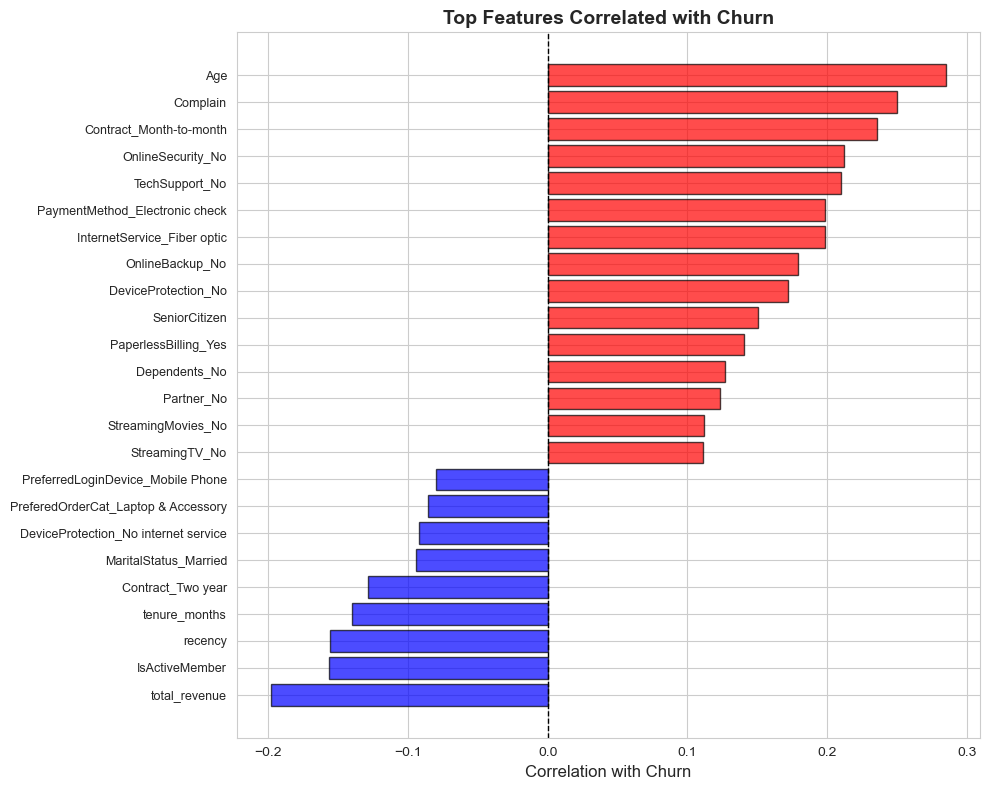

In [ ]:
# Compute correlation with target variable
numerical_features = D_public_processed.select_dtypes(include=[np.number]).columns.tolist()

# Remove target and identifier from correlation
features_for_corr = [f for f in numerical_features if f not in ['churned', 'dataset_source']]

if len(features_for_corr) > 0:
    correlations = D_public_processed[features_for_corr + ['churned']].corr()['churned'].drop('churned')
    correlations = correlations.sort_values(ascending=False)
    
    # Top positive correlations
    print("Top 10 Features Positively Correlated with Churn:\n")
    print(correlations.head(10))
    
    # Top negative correlations
    print("\nTop 10 Features Negatively Correlated with Churn:\n")
    print(correlations.tail(10))
    
    # Visualize top correlations
    fig, ax = plt.subplots(figsize=(10, 8))
    
    top_pos = correlations.head(15)
    top_neg = correlations.tail(15)
    top_combined = pd.concat([top_pos, top_neg]).drop_duplicates().sort_values()
    
    colors = ['red' if x > 0 else 'blue' for x in top_combined.values]
    ax.barh(range(len(top_combined)), top_combined.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(top_combined)))
    ax.set_yticklabels(top_combined.index, fontsize=9)
    ax.set_xlabel('Correlation with Churn', fontsize=12)
    ax.set_title('Top Features Correlated with Churn', fontsize=14, fontweight='bold')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig('../results/figures/feature_correlations.png', dpi=150)
    plt.show()
else:
    print("No numerical features for correlation analysis.")

## 9. Save Processed Dataset

Save the fully processed unified dataset for train/test splitting.

In [11]:
# Create harmonized directory
harmonized_dir = Path('../data/harmonized')
harmonized_dir.mkdir(parents=True, exist_ok=True)

# Save processed dataset
output_path = harmonized_dir / 'D_public_processed.csv'
D_public_processed.to_csv(output_path, index=False)

print(f"✓ Processed dataset saved to: {output_path}")
print(f"  Shape: {D_public_processed.shape}")
print(f"  Size: {output_path.stat().st_size / (1024**2):.2f} MB")

# Save scaler for later use
import pickle
scaler_path = harmonized_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"\n✓ Scaler saved to: {scaler_path}")

✓ Processed dataset saved to: ../data/harmonized/D_public_processed.csv
  Shape: (22673, 92)
  Size: 6.36 MB

✓ Scaler saved to: ../data/harmonized/scaler.pkl


## 10. Dataset Summary

Generate final summary statistics.

In [ ]:
print("\n" + "="*70)
print("FINAL DATASET SUMMARY")
print("="*70)

print(f"\nDataset: D_public_processed")
print(f"  Total Observations: {len(D_public_processed):,}")
print(f"  Total Features: {D_public_processed.shape[1]}")

print(f"\nDataset Source Breakdown:")
source_counts = D_public_processed['dataset_source'].value_counts()
for source, count in source_counts.items():
    pct = (count / len(D_public_processed)) * 100
    print(f"  {source:12} {count:>6,} ({pct:>5.1f}%)")

print(f"\nTarget Variable (churned):")
churn_counts = D_public_processed['churned'].value_counts()
for value, count in churn_counts.items():
    label = 'Retained' if value == 0 else 'Churned'
    pct = (count / len(D_public_processed)) * 100
    print(f"  {label:12} {count:>6,} ({pct:>5.1f}%)")

overall_churn = D_public_processed['churned'].mean()
print(f"\nOverall Churn Rate: {overall_churn:.3f} ({overall_churn*100:.1f}%)")

print(f"\nFeature Engineering Applied:")
print(f"  ✓ Rare category consolidation (threshold=1%)")
print(f"  ✓ Numerical feature normalization (StandardScaler)")
print(f"  ✓ Categorical feature encoding (one-hot)")

print(f"\nOutput Files:")
print(f"  - {output_path}")
print(f"  - {scaler_path}")